#🔹 Step 1: Data Preparation

We start by reading a dataset of names and extracting all unique characters:

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

words = open('/content/names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))


In [2]:
len(words)

32033

#🔹 Step 2: Vocabulary & Tokens

We start by creating a mapping between characters and integers — the language our neural network can understand.

In [3]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)

#🔹 Step 3: Context Windows

We move beyond bigrams (2-character context) to a context window of 3 characters — meaning the model predicts the next character using the last three.

Feature vector represents different aspects of the word

In [4]:
block_size=3
def build_dataset(words):
  X,Y=[],[]
  for w in words:
    context=[0]*block_size
    for ch in w+'.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:]+[ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)

  print(X.shape,Y.shape)
  return X,Y



#🔹 Step 4: Train–Validation–Test Split

We shuffle the data and create three sets to train, tune, and evaluate our model fairly.

🎯 **Reasoning:**

Training set (80%) – used for learning model weights.

Validation set (10%) – checks performance during training to avoid overfitting.

Test set (10%) – measures how well the model generalizes to unseen data.

In [30]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [31]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


#🔹 Step 4: Model Architecture – MLP From Scratch

We’ll use the following components:

**Embedding layer (C)** → turns character tokens into dense vectors.

**Hidden layer (w1, b1)** → introduces nonlinearity.

**Output layer (w2, b2)** → predicts next-character probabilities.

**Batch normalization (bngain, bnbias)** → helps stabilize and speed up training.

#Basic implementation

c = torch.randn((27, 2))
Creates a table of 27 random vectors, each with 2 numbers.
Think of it as an embedding table.

emb = c[Xtr]
Uses the numbers in Xtr as indexes to pick rows from c.
This is how embedding lookup works.

emb.shape
Shows the size of the resulting embeddings.
The shape will be (len(Xtr), 2) or (B, T, 2) if Xtr is multi-dimensional.

In [42]:
import torch

# Create a random embedding matrix of size (27, 2)
# - 27 = number of possible tokens (for example, 26 letters + 1 special token)
# - 2  = embedding dimension (each token becomes a 2-number vector)
c = torch.randn((27, 2))

# Xtr must be a tensor of integers.
# Each number in Xtr selects (indexes) a row from 'c'.
# This is how embedding lookup works.
emb = c[Xtr]

# Show the shape of the resulting embedding tensor.
# Shape = (number of items in Xtr, 2)
emb.shape


torch.Size([182437, 3, 2])

In [43]:
w1 = torch.randn((6, 100))   # Weight matrix for the first layer: 6 inputs → 100 outputs
b1 = torch.randn(100)        # Bias vector for the 100 output neurons

# emb.view(-1, 6) reshapes the embeddings so that each item becomes a vector of length 6
# @ performs matrix multiplication: (N,6) @ (6,100) → (N,100)
# + b1 adds the bias to each of the 100 outputs
# torch.tanh(...) applies the tanh activation function
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)

h


tensor([[-5.6336e-02,  1.0793e-01, -1.2540e-01,  ..., -9.8291e-01,
          9.4040e-01,  9.5749e-04],
        [ 6.4760e-02,  9.9981e-01,  7.7487e-01,  ...,  8.2673e-01,
         -9.5720e-01,  8.4189e-01],
        [ 9.9154e-01,  8.7187e-01,  6.4494e-01,  ...,  6.1580e-02,
         -9.9105e-01, -9.5456e-01],
        ...,
        [-7.5003e-01, -9.7972e-01,  7.8104e-01,  ..., -9.6711e-01,
          8.7694e-01, -7.1935e-01],
        [-5.7866e-02,  6.7485e-01, -4.5903e-01,  ..., -9.9606e-01,
          8.7121e-01,  1.8651e-01],
        [ 7.4339e-01, -2.6823e-02, -3.4960e-01,  ...,  4.5612e-01,
         -5.7201e-01, -5.3100e-01]])

In [44]:
w2 = torch.randn((100, 27))   # Second layer weights: 100 hidden → 27 output classes
b2 = torch.randn(27)          # Bias for each of the 27 classes

# Compute raw class scores (logits)
# h @ w2:   (N,100) @ (100,27) = (N,27)
logits = h @ w2 + b2

# Convert logits to positive values
counts = logits.exp()

# Convert to probabilities by dividing by the sum along each row
# This is basically the "softmax" operation
probs = counts / counts.sum(1, keepdims=True)

# Final probability distribution for each input
probs.shape


torch.Size([182437, 27])

In [45]:
# Select the probability that the model assigned to the *correct* class for each training example
# torch.arange(len(Ytr)) → [0, 1, 2, ..., N-1]
# Ytr contains the correct class labels
correct_probs = probs[torch.arange(len(Ytr)), Ytr]

# Compute the negative log-likelihood loss (cross-entropy)
# -log(correct probability)
loss = -correct_probs.log().mean()

loss


tensor(15.3641)

In [46]:
# Set up a random number generator with a fixed seed so results are always the same.
# This is called *reproducibility* — same inputs → same outputs every time.
g = torch.Generator().manual_seed(2147483647)

# C: Embedding matrix
# 27 possible tokens (e.g., characters) and each is represented by a 10-dimensional vector.
C = torch.randn((27, 10), generator=g)

# W1 and b1: Weights and bias of the 1st hidden layer
# Input size = 30, hidden layer size = 200
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# W2 and b2: Weights and bias of the output layer
# Hidden size = 200, output classes = 27
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Put all the model parameters into a single list
parameters = [C, W1, b1, W2, b2]


In [47]:
# Count how many total parameters the model has.
# p.nelement() = number of elements in a tensor
# We sum over all model parameters: C, W1, b1, W2, b2
total_params = sum(p.nelement() for p in parameters)

total_params


11897

In [48]:
# Tell PyTorch to track gradients for ALL model parameters.
# This is required for backpropagation.
for p in parameters:
    p.requires_grad = True

# Create a range of exponent values from -3 to 0 (1000 values)
# Example: -3, -2.99, -2.98, ..., 0
lre = torch.linspace(-3, 0, 1000)

# Convert them to actual learning rates by raising 10 to those powers.
# This produces values like: 1e-3, 1.002e-3, ..., 1.0
lrs = 10 ** lre

# Prepare empty lists to log training data
lri = []   # learning rate index
lossi = [] # loss values
stepi = [] # training step numbers


In [49]:
for i in range(200000):    # Run 200,000 training iterations

    # -----------------------------
    # 1. Create a random minibatch
    # -----------------------------
    ix = torch.randint(0, Xtr.shape[0], (32,))  # pick 32 random training examples

    # -----------------------------
    # 2. Forward pass (predict)
    # -----------------------------
    emb = C[Xtr[ix]]               # Lookup embeddings → (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # Hidden layer → (32, 200)
    logits = h @ W2 + b2           # Output scores → (32, 27)

    # Compute cross-entropy loss between logits and true labels
    loss = F.cross_entropy(logits, Ytr[ix])#cross entropy because in manual way logits have big number like 100 in softmax epow(100) becomes huge and inf if low like epow(-100) becomes 0 this cross entropy solves this

    # -----------------------------
    # 3. Backward pass (compute gradients)
    # -----------------------------
    for p in parameters:
        p.grad = None              # Reset gradients to zero (important!)
    loss.backward()                # Backprop: compute gradients

    # -----------------------------
    # 4. Update parameters (SGD)
    # -----------------------------
    # Use large LR first, then smaller LR later
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad     # Gradient descent update

    # -----------------------------
    # 5. Track learning stats
    # -----------------------------
    stepi.append(i)
    lossi.append(loss.log10().item())

# Print final loss at the end
print(loss.item())


1.9607923030853271


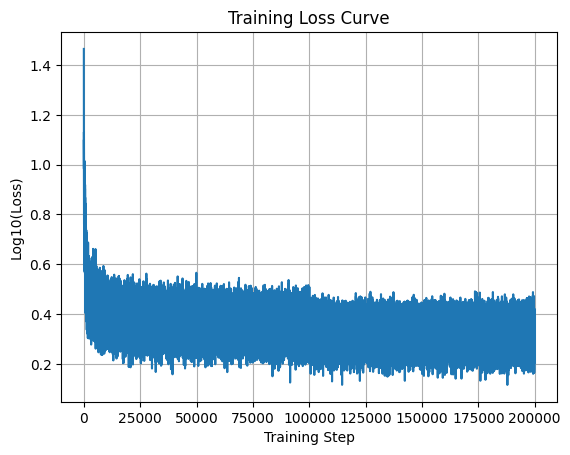

In [50]:
import matplotlib.pyplot as plt

# Plot training progress
# X-axis: training steps
# Y-axis: loss (log10 scale)
plt.plot(stepi, lossi)
plt.xlabel("Training Step")
plt.ylabel("Log10(Loss)")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [51]:
# 1. Lookup embeddings for each token in the input
# Xtr contains token indices
emb = C[Xtr]  # shape example: (32, 3, 10)

# 2. Flatten embeddings and pass through the first layer
# emb.view(-1, 30): each sample becomes a 30-dim vector (3 tokens * 10 dims)
# @ W1 + b1: linear transformation to hidden layer
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # hidden layer output (32, 100)

# 3. Output layer: compute raw class scores (logits)
logits = h @ W2 + b2  # shape: (32, 27)

# 4. Compute cross-entropy loss between logits and true labels
loss = F.cross_entropy(logits, Ytr)

# Show the loss
loss


tensor(2.1219, grad_fn=<NllLossBackward0>)

In [52]:
# 1. Lookup embeddings for dev set token indices
emb = C[Xdev]  # shape: (batch_size, 3 tokens, embedding_dim)

# 2. Flatten embeddings and pass through the hidden layer
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # hidden layer output

# 3. Compute logits (raw scores) for each class
logits = h @ W2 + b2  # shape: (batch_size, 27)

# 4. Compute cross-entropy loss using true dev labels
loss = F.cross_entropy(logits, Ydev)

# Display dev loss
loss


tensor(2.1776, grad_fn=<NllLossBackward0>)

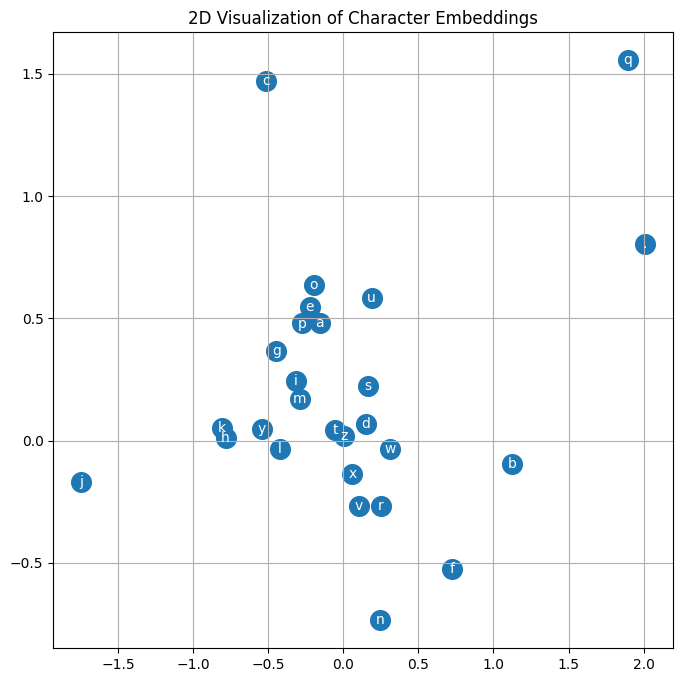

In [53]:
import matplotlib.pyplot as plt

# Create a square figure
plt.figure(figsize=(8,8))

# Scatter plot of the first two embedding dimensions
# Each point represents a character
plt.scatter(C[:,0].data, C[:,1].data, s=200)

# Add text labels for each character at its corresponding point
for i in range(C.shape[0]):
    plt.text(
        C[i,0].item(),  # x-coordinate
        C[i,1].item(),  # y-coordinate
        itos[i],        # character label
        ha="center", va="center", color='white'
    )

# Add a minor grid for reference
plt.grid('minor')

plt.title("2D Visualization of Character Embeddings")
plt.show()


# Part 2 Activation & Gradients,BatchNorms

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('/content/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#🔹 1. Why is the loss huge in the beginning?

At the very start, the network is random.

Since there are **27 classes (characters)**, the model’s first prediction is:

    P(each character) ≈ 1/27


Cross-entropy loss for random guessing is:

    −log(1/27) ≈ 3.295


So loss **≈ 3.3 is normal** early in training.

#🔹 2. Forward pass: logits → softmax → probabilities

The main pipeline is:

    logits = h @ W2 + b2
    probs = exp(logits) / sum(exp(logits))
    loss = -log(probability of correct class)


Softmax converts scores (logits) into probabilities.

#🔹 3. Logit scale controls how “hard” or “soft” predictions are
**✔️ Small differences → soft probabilities**

Example: [1.0, 1.1] → model unsure

**✔️ Large differences → hard probabilities**

Example: [1.0, 10.0] → model very confident

**⚠️ Too large logits → exp() overflows → NaN**

You must keep logits in a reasonable range.

#🔹 4. Logit scaling trick

To control magnitude:

Keep **b2 = 0**

Scale W2:

    W2 *= 0.1


This normalizes output scale and stabilizes softmax.

#🔹 5. Why tanh can kill gradients (saturation problem)

Hidden layer:

    hpreact = emb_flat @ W1 + b1
    h = torch.tanh(hpreact)


Derivative of tanh:

    tanh'(x) = 1 - tanh(x)^2


If **hpreact** is large:

    tanh(hpreact) ≈ ±1 → gradient ≈ 0 → neuron stops learning


This is called a **dead neuron**.

#🔹 6. Prevent saturation: control hpreact scale

We want:

    hpreact ≈ Gaussian with std ≈ 1


Fixes:

**✔️ Quick fix**
    W1 *= 0.1

**✔️ Correct fix: Xavier initialization (recommended for tanh)**
    std = (5/3) / sqrt(n_emb * block_size)
    W1 = torch.randn(...) * std


This keeps tanh in a healthy operating range.

#🔹 7. Why BatchNorm helps

Even with good initialization, **hpreact** distribution drifts during training.
BatchNorm fixes it:

**hpreact_normalized = (hpreact - mean) / std**


This ensures:

-No saturation

-Smoother gradients

-Faster learning

-Stable training

**Then we apply learnable scaling:**
    hpreact_out = bngain * hpreact_normalized + bnbias


Where:

**bngain** adjusts output variance

**bnbias** shifts mean

They allow network flexibility after normalization

#🔹 8. BatchNorm requires running averages

During **training**, mean & std come from each batch.
During **inference**, we must use global averages.

So we maintain:

    bnmean_running = torch.zeros((1, n_hidden))
    bnstd_running  = torch.ones((1, n_hidden))


These store a **moving average** of batch statistics.

#🔹 9. BatchNorm parameters (your added code)
    bngain = torch.ones((1, n_hidden))     # learnable scaling (gamma)
    bnbias = torch.zeros((1, n_hidden))    # learnable shift (beta)

    bnmean_running = torch.zeros((1, n_hidden))  # running mean for inference
    bnstd_running  = torch.ones((1, n_hidden))   # running std  for inference

**What each does:**

bngain (gamma)-	Scales normalized activations	-Allows network to stretch / amplify features
bnbias (beta)-	Shifts normalized activations	-Allows network to shift features
bnmean_running-	Global running mean	-Used during inference
bnstd_running-	Global running std-	Ensures consistent scaling during inference

These make BatchNorm fully functional in both training and evaluation.

#🔹 10. Summary: what we learned
✔️ Initial loss ~3.3 is normal

✔️ Logits must be scaled or softmax explodes

✔️ Tanh saturates when inputs too large → dead neurons

✔️ Weight scaling + Xavier init fix saturation

✔️ BatchNorm ensures stable, Gaussian activations

✔️ BatchNorm parameters (gain, bias, running stats) give flexibility & stability

✔️ Good scaling → good gradients → stable and fast learning

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


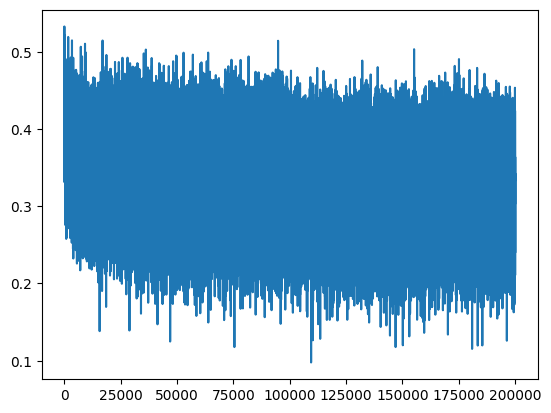

In [8]:
plt.plot(lossi)

In [9]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


#loss log
#original:
train 2.1245384216308594 val 2.168196439743042

#fix softmax confidently wrong:
train 2.07 val 2.13

#fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

#use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

#add batch norm layer
train 2.0668270587921143 val 2.104844808578491

#**converting more into pytorch**

In [11]:
class Linear:
  def __init__(self,fan_in,fan_out,bias=True):
    self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
    self.bias=torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out=x@self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])


class BatchNorm1d:
  def __init__(self,dim,eps=1e-5,momentum=0.1):
    self.eps=eps
    self.momentum=momentum
    self.training=True
    self.gamma=torch.ones(dim)
    self.beta=torch.zeros(dim)
    self.running_mean=torch.zeros(dim)
    self.runnin_var=torch.ones(dim)

  def __call__(self,x):
    if self.training:
      xmean=x.mean(0,keepdim=True)#batch mean
      xvar=x.var(0,keepdim=True)#batch varence

    else:
      xmean=self.running_mean
      xvar=self.running_var
    xhat=(x-xmean)/torch.sqrt(xvar+self.eps)
    self.out=self.gamma*xhat+self.beta
    if self.training:
      with torch.no_grad():
        self.runnning_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
        self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]


class Tanh:
  def __call__(self,x):
    self.out=torch.tanh(x)
    return self.out
  def parameters(self):
    return []



n_embd=10
n_hidden=100
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),          generator=g)
layers=[
    Linear(n_embd*block_size,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),
]

with torch.no_grad():
  layers[-1].weight*=0.1
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight*=5/3

parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True

46497


In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2944


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


/tmp/ipython-input-1625259626.py:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

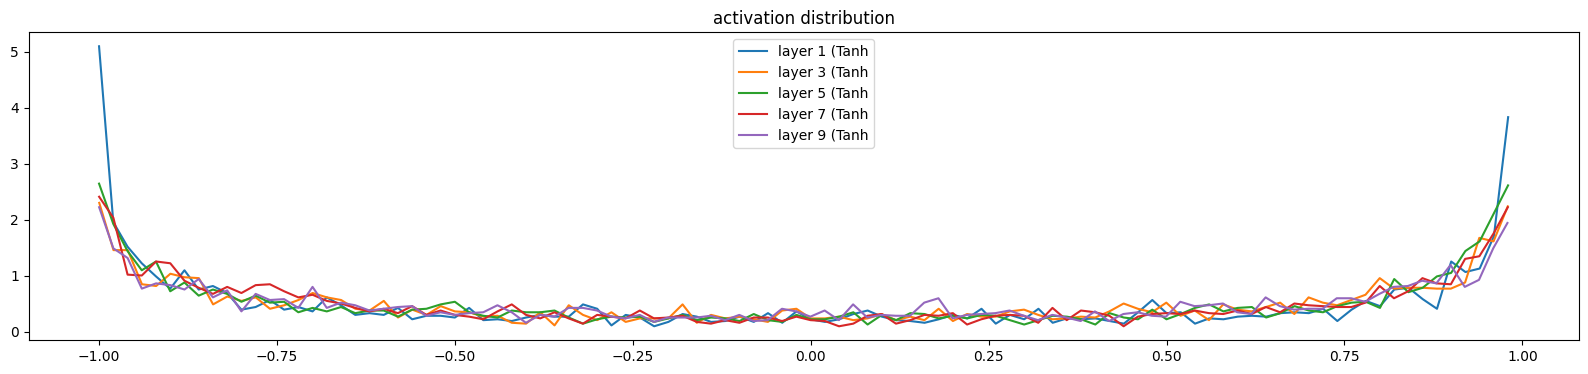

In [15]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085332e-03
layer 5 (      Tanh): mean -0.000007, std 2.888205e-03
layer 7 (      Tanh): mean +0.000012, std 2.756316e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'gradient distribution')

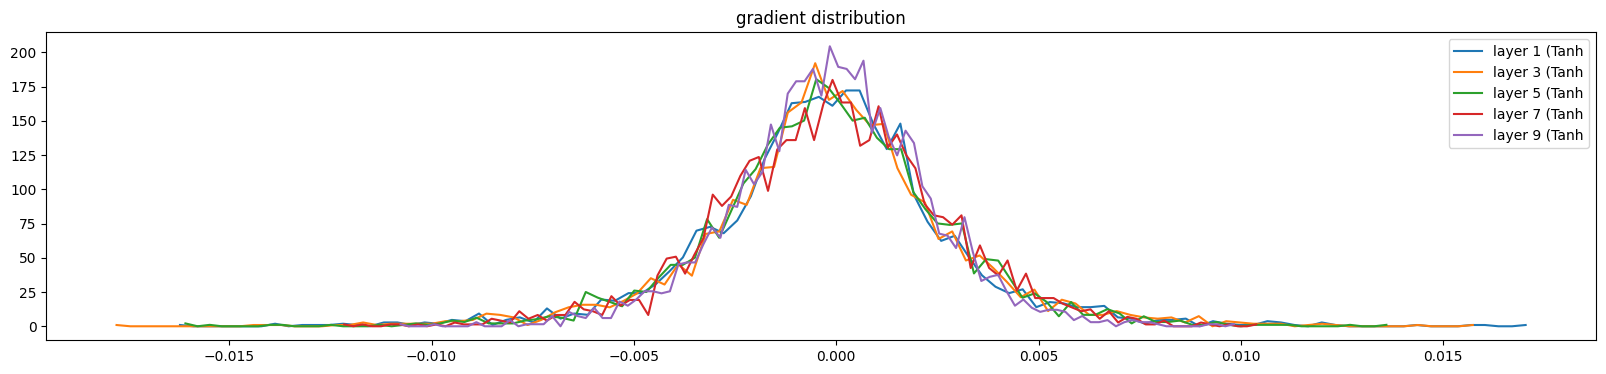

In [16]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000772 | std 9.714620e-03 | grad:data ratio 9.714506e-03
weight  (30, 100) | mean -0.000036 | std 8.734044e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242009e-03 | grad:data ratio 3.681915e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.221999e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229574e-01


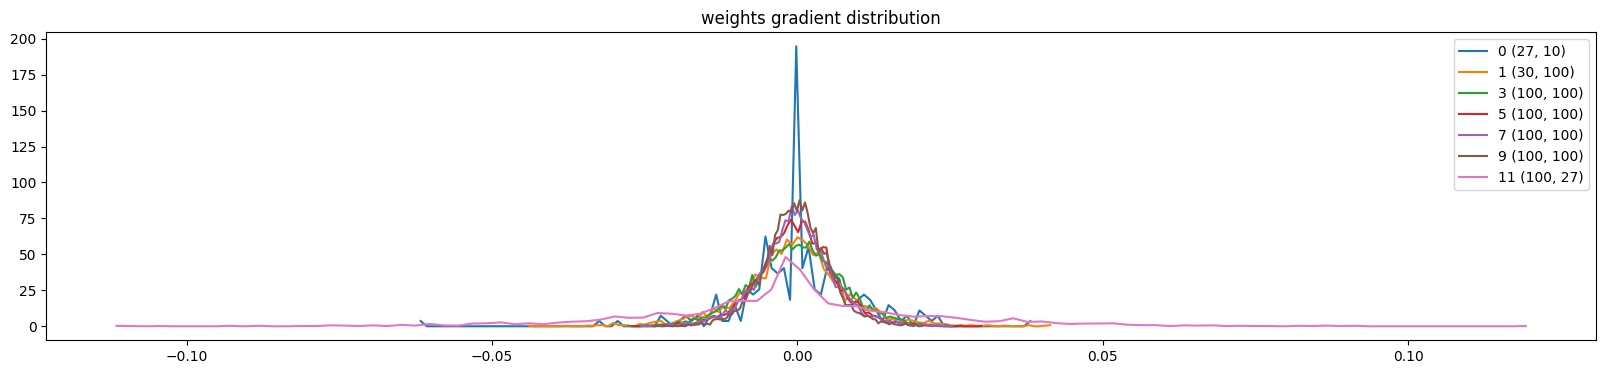

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

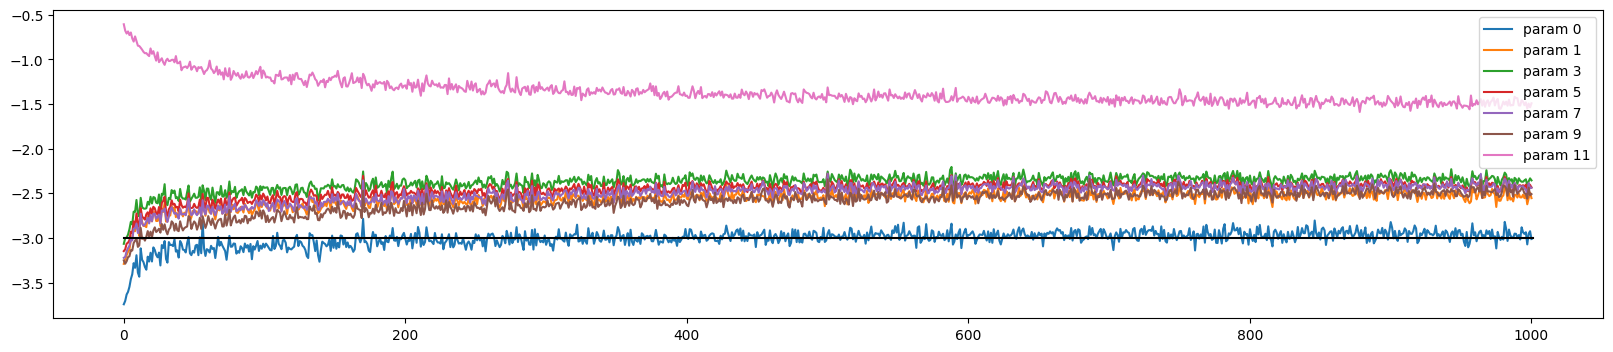

In [18]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.362014055252075
val 2.369659423828125


In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carpahrato.
harih.
jariahth.
caskandene.
mahnen.
ameraht.
areli.
neroniahceriiv.
arleigy.
ham.
pori.
quint.
sroine.
live.
quoroe.
padiaryrix.
kaeelinsan.
edre.
oia.
gile.
